In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from Utilities.basic_units import radians

from Utilities.operators import make_tree
import Utilities.prelude

In [2]:
folder = 'TDE'
is_tde = True
snap = '196'
m = 5
beta = 2 
path = f'{folder}/{snap}'
Rt =  (10**m)**(1/3)
Rp = Rt / beta

In [3]:
# Find keplerian orbit
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def keplerian_orbit(theta, p = Rt, ecc = 0.999):
    radius = p / (1 + ecc * np.cos(theta))
    return radius

# def eq_motion(x0, y0, t, r_vel = Rt, M_bh = 10**m):
#     vel = M_bh / r_vel**3 # G = 1
#     x = x0 + 
#     y = x0 + vel * t
#     return x, y 

In [4]:
# Load data
_, X, Y, Z, Vol, VX, VY, VZ, _, Den, Press, Temp, _, Entropy = make_tree(path, snap, is_tde = True, energy=True)
dim_cell = Vol**(1/3) # according to Elad

In [94]:
# Import data for shockzone
shockzone = np.loadtxt(f'data/{snap}/MASKshockzone_{snap}.txt')

idx_zone = shockzone[0]
idx_zone = np.array([int(i) for i in idx_zone])
x_zone = X[idx_zone]
y_zone = Y[idx_zone]
z_zone = Z[idx_zone]
dim_cell_zone = dim_cell[idx_zone]


shocksurface = np.loadtxt(f'data/{snap}/MASKshocksurface_{snap}.txt')

idx_surf = shocksurface[0]
idx_surf = np.array([int(i) for i in idx_surf])
x_surf = x_zone[idx_surf]
y_surf = y_zone[idx_surf]
z_surf = z_zone[idx_surf]
dim_cell_surf = dim_cell_zone[idx_surf]

Shiokawa in y-z (at second pericenter passage, i.e. X= Rp)

In [98]:
# cross section
cross_sect = np.abs(X-Rp)< dim_cell
lim = np.logical_and(np.abs(Y)<100, np.abs(Z)<50)
conditions = np.logical_and(cross_sect, lim)
Y_shio = Y[conditions]
Z_shio = Z[conditions]
VY_shio = VY[conditions]
VZ_shio = VZ[conditions]
Den_shio = Den[conditions]
Entropy_shio = Entropy[conditions]
shio_tree = KDTree(np.transpose([Y_shio, Z_shio]))

cross_sect_surf = np.abs(x_surf-Rp)< dim_cell_surf
lim_surf = np.logical_and(np.abs(y_surf)<100, np.abs(z_surf)<50)
conditions_surf = np.logical_and(cross_sect_surf, lim_surf)
y_surf_shio = y_surf[conditions_surf]
z_surf_shio = z_surf[conditions_surf]


Text(0.5, 1.0, 'Cross section, X = $R_p$')

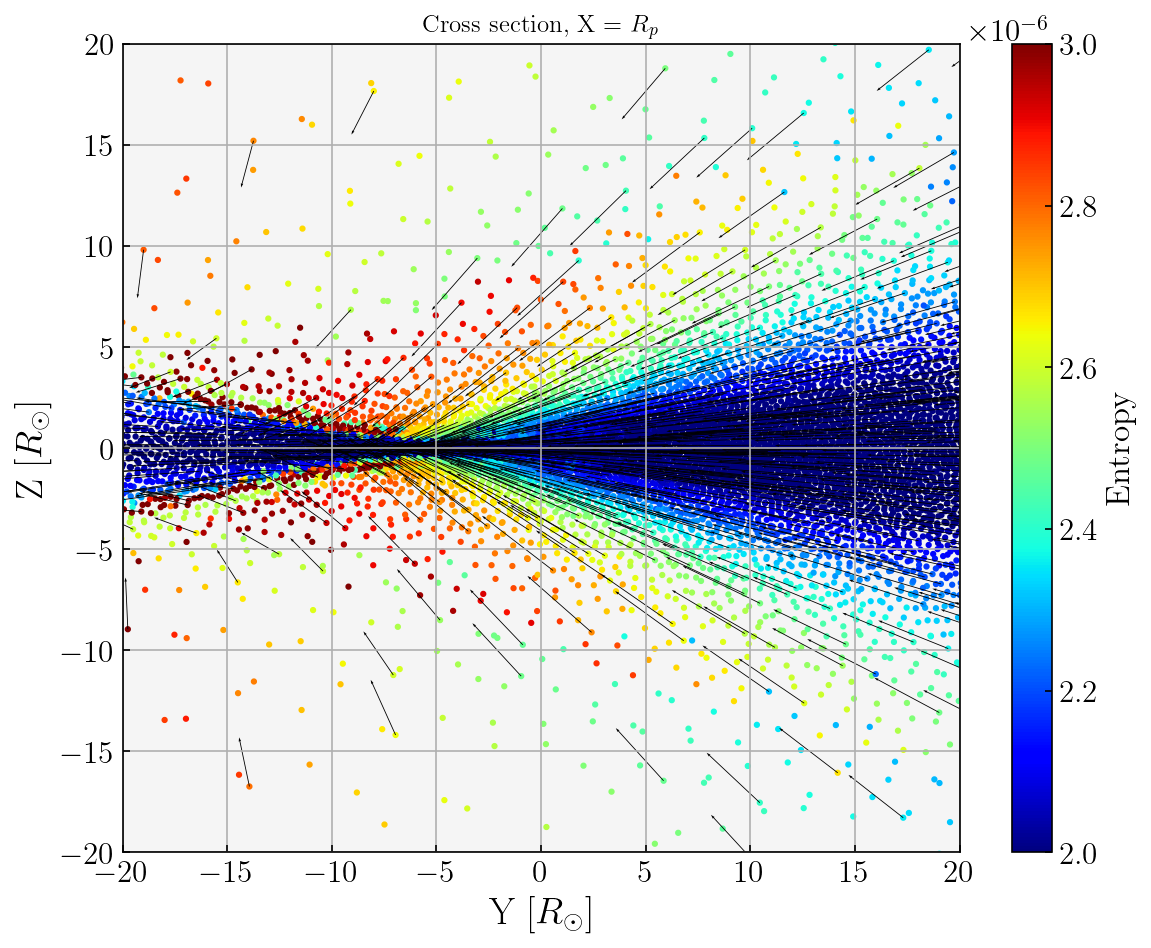

In [104]:
fig, ax = plt.subplots(1,1, figsize = (9,7))
img = ax.scatter(Y_shio, Z_shio, c = Entropy_shio, s = 4, cmap = 'jet', vmin = 2e-6, vmax = 3e-6)
ax.quiver(Y_shio[::10], Z_shio[::10], VY_shio[::10], VZ_shio[::10], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 20)
#ax.plot(x_zone, z_zone, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.set_xlabel(r'Y [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, X = $R_p$')
#plt.savefig(f'Figs/EntropyYZ_{snap}.png')

In [6]:
# extend data for the plot
Y_shio_interp = np.arange(np.min(Y_shio), np.max(Y_shio))
Z_shio_interp = np.arange(np.min(Z_shio), np.max(Z_shio), 0.1)
Entropy_shio_interp = np.zeros((len(Y_shio_interp), len(Z_shio_interp)))

for i in range(len(Y_shio_interp)):
    for j in range(len(Z_shio_interp)):
        point = np.array([Y_shio_interp[i], Z_shio_interp[j]])
        _, idx = shio_tree.query(point)
        Entropy_shio_interp[i, j] = Entropy_shio[idx]

Text(0.5, 1.0, 'Cross section at X = $R_p$')

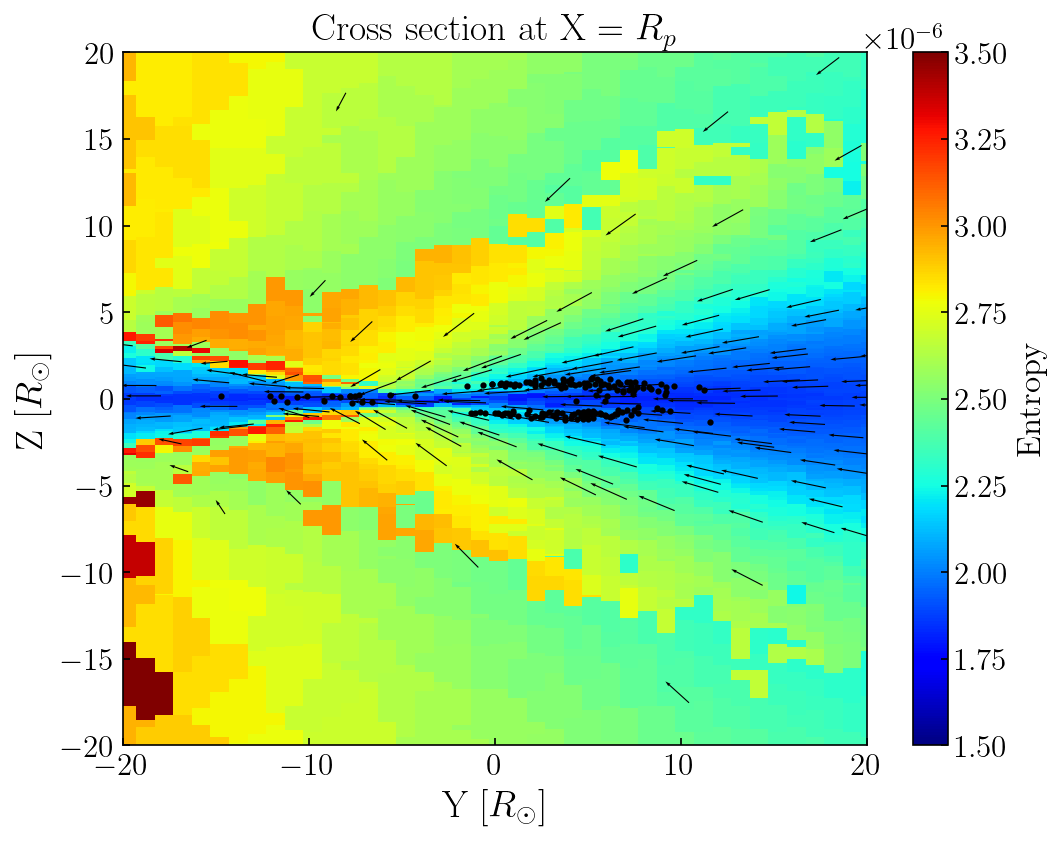

In [103]:
plt.figure()
img = plt.pcolormesh(Y_shio_interp, Z_shio_interp, Entropy_shio_interp.T, cmap = 'jet', vmin = 1.5e-6, vmax = 3.5e-6)
plt.quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'Entropy', fontsize = 16)
plt.scatter(y_surf_shio, z_surf_shio, s = 4, color='k')
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section at X = $R_p$', fontsize = 18)

Text(0.5, 1.0, 'Cross section at X = $R_p$')

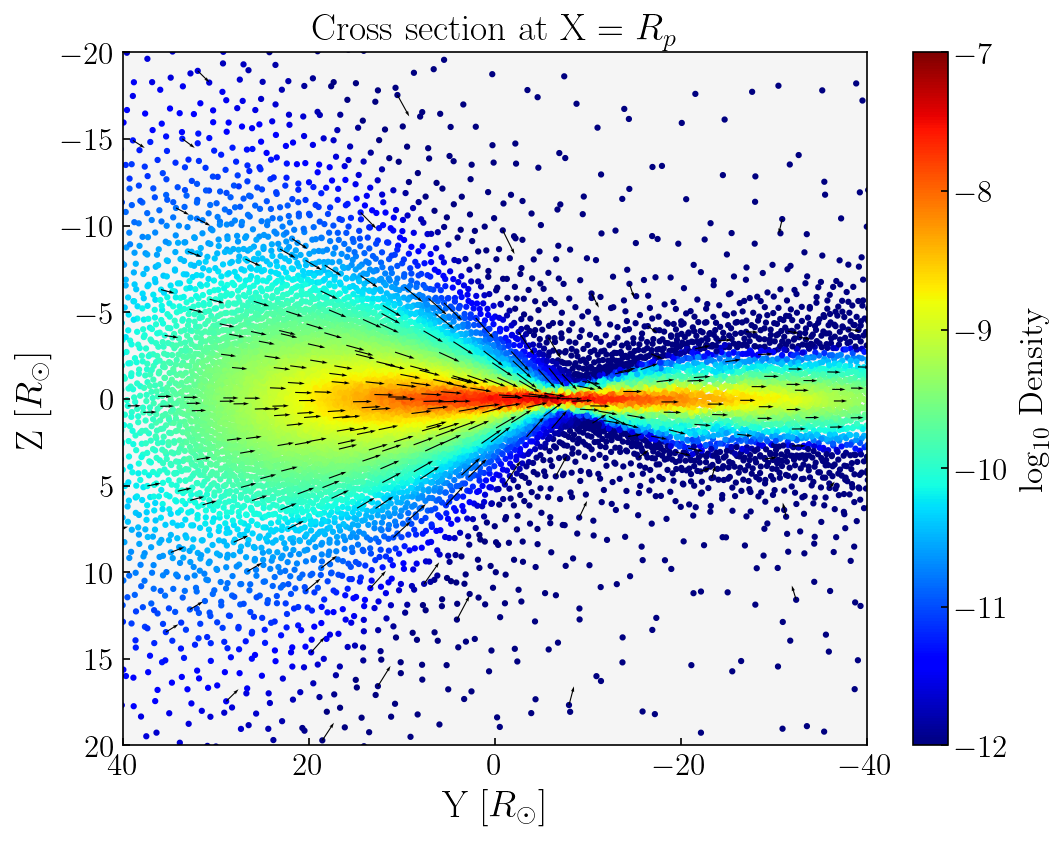

In [93]:
plt.figure()
img = plt.scatter(Y_shio, Z_shio, c = np.log10(Den_shio), s = 4, cmap = 'jet', vmin = -12, vmax = -7)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
plt.quiver(Y_shio[::40], Z_shio[::40], VY_shio[::40], VZ_shio[::40], color = 'k', angles='xy', scale_units='xy', width = 1.5e-3, scale = 40)
plt.xlim(-40,40)
plt.gca().invert_xaxis()
plt.ylim(20,-20)
plt.xlabel(r'Y [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section at X = $R_p$', fontsize = 18)

Midplane and keplerian orbit

In [9]:
# cross section midplane
X_midplane = X[np.abs(Z) < dim_cell]
Y_midplane = Y[np.abs(Z) < dim_cell]
VX_midplane = VX[np.abs(Z) < dim_cell]
VY_midplane = VY[np.abs(Z) < dim_cell]
Vol_midplane = Vol[np.abs(Z) < dim_cell]
Temp_midplane = Temp[np.abs(Z) < dim_cell]
Den_midplane = Den[np.abs(Z) < dim_cell]
Entropy_midplane = Entropy[np.abs(Z) < dim_cell]

In [10]:
# keplerian orbit and tidal radius
theta_arr = np.arange(0, 2*np.pi, 0.01)
orbit = keplerian_orbit(theta_arr)
x_orbit, y_orbit = from_cylindric(orbit, theta_arr) 

delta_r = 5
lower_orbit = orbit - delta_r
x_lower_orbit, y_lower_orbit = from_cylindric(lower_orbit, theta_arr) 
upper_orbit = orbit + delta_r
x_upper_orbit, y_upper_orbit = from_cylindric(upper_orbit, theta_arr) 

# cfr tidal disrutption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

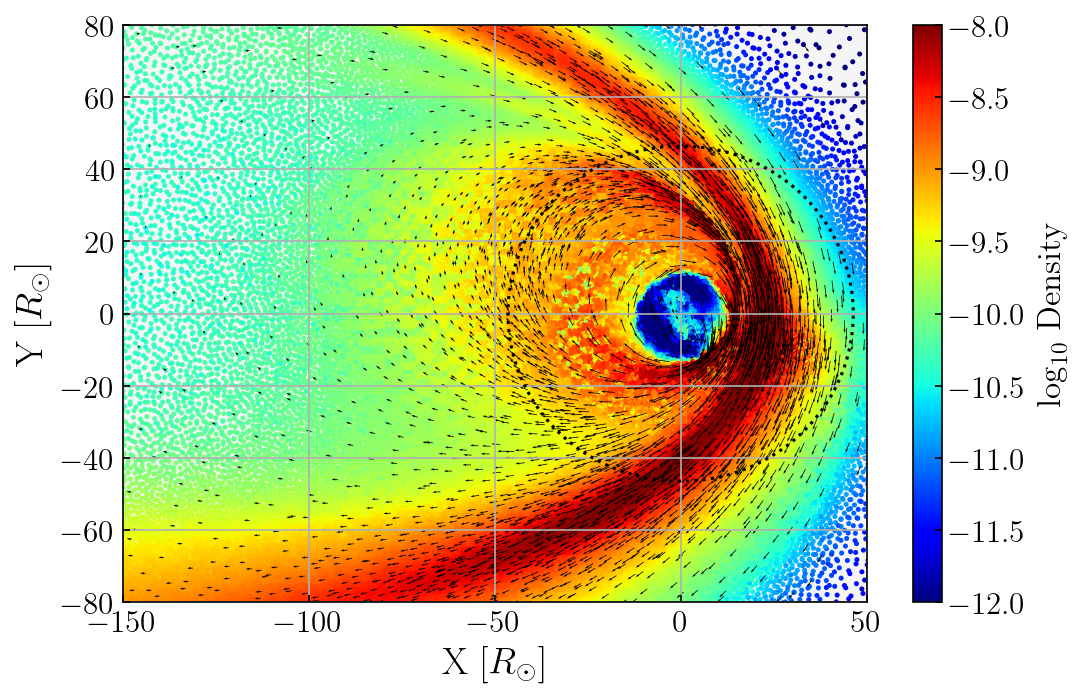

In [11]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
img = ax.scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -8)
ax.quiver(X_midplane[::50], Y_midplane[::50], VX_midplane[::50], VY_midplane[::50], color = 'k', angles='xy', scale_units='xy', width = 1e-3)#, scale = 40)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
# ax.scatter(x_orbit, y_orbit, color = 'k', s = 4)
# ax.scatter(x_lower_orbit, y_lower_orbit, color = 'k', s = 2)
# ax.scatter(x_upper_orbit, y_upper_orbit, color = 'k', s = 2)
ax.set_xlim(-150,50)
ax.set_ylim(-80,80)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()


s-z plane

In [84]:
RADIUS, THETA = to_cylindric(X, Y)
theta_chosen = 0
radius_chosen = keplerian_orbit(theta_chosen)
x_chosen, y_chosen = from_cylindric(radius_chosen, theta_chosen)
condition_sz = np.logical_and(np.abs(keplerian_orbit(THETA)-RADIUS)<dim_cell, np.abs(theta_chosen - THETA) < np.pi/2)
X_sz = X[condition_sz]
Y_sz = Y[condition_sz]
Z_sz = Z[condition_sz]
Den_sz = Den[condition_sz]
theta_sz = THETA[condition_sz]

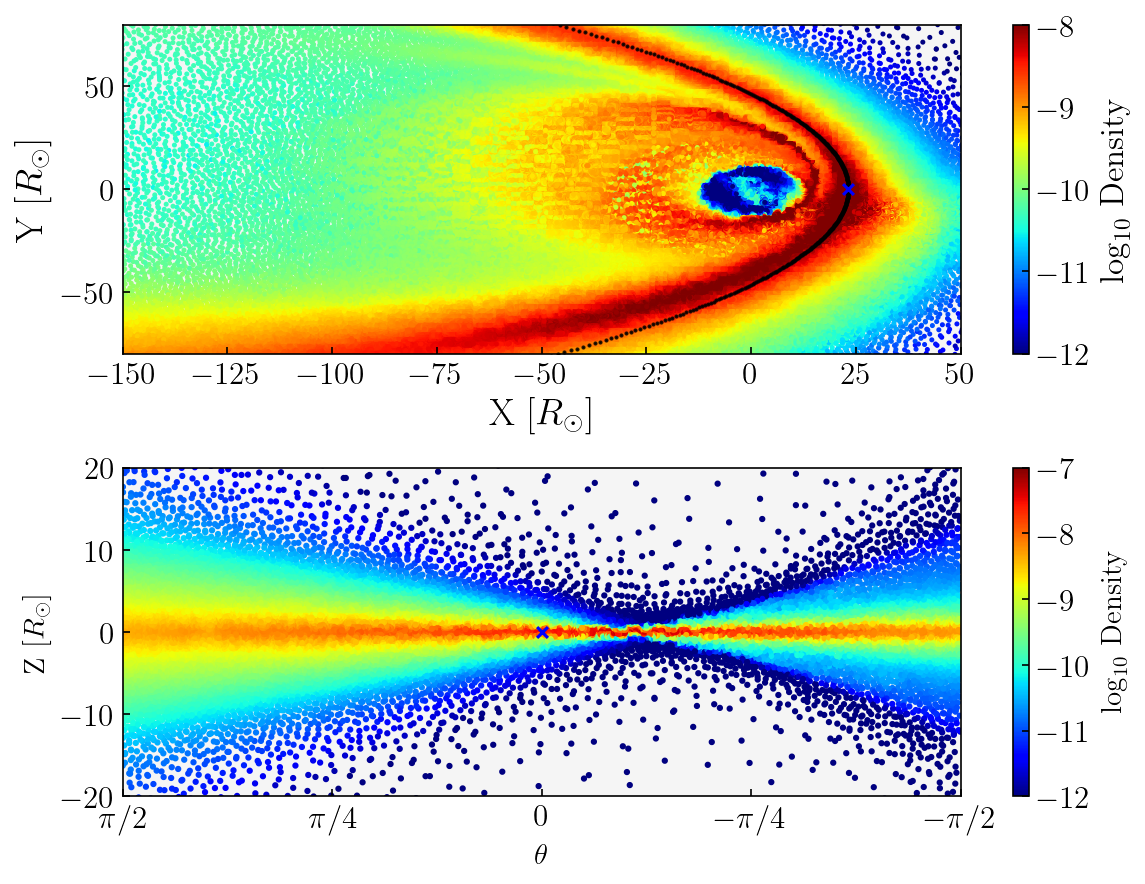

In [85]:
fig, ax = plt.subplots(2,1)
img = ax[0].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = 2, cmap = 'jet', vmin = -12, vmax = -8)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].scatter(x_orbit, y_orbit, color = 'k', s = 1, alpha = 0.8)
ax[0].scatter(x_chosen, y_chosen, marker = 'x', s = 27, c = 'b')
ax[0].set_xlim(-150,50)
ax[0].set_ylim(-80,80)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(theta_sz* radians, Z_sz, xunits=radians, c = np.log10(Den_sz),  cmap = 'jet', s = 4, vmin = -12, vmax = -7)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Density', fontsize = 14)
ax[1].scatter(theta_chosen, 0, marker = 'x', s = 27, c = 'b')
if theta_chosen < np.pi :
    ax[1].invert_xaxis()
    ax[1].set_xlim(theta_chosen + np.pi/2, theta_chosen - np.pi/2)
else: 
    ax[1].xlim(theta_chosen-np.pi/2, theta_chosen+np.pi/2)
ax[1].set_ylim(-20,20)
ax[1].set_xlabel(r'$\theta$', fontsize = 14)
ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 14)

plt.tight_layout()

(0.0, 250.0)

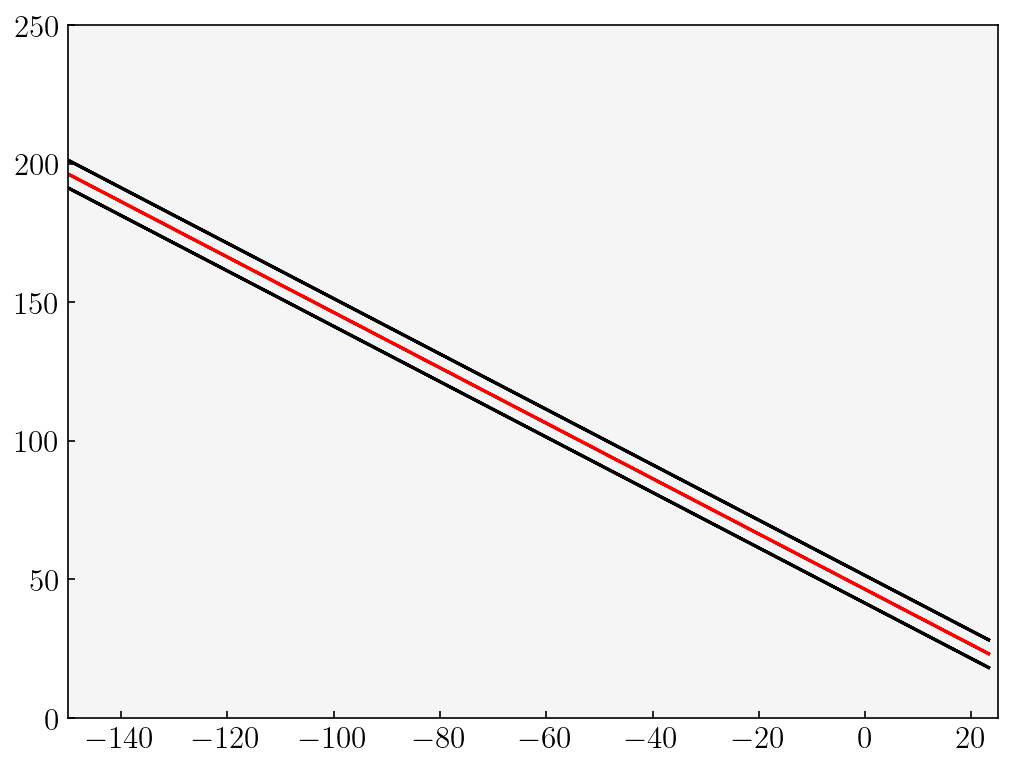

In [86]:
plt.plot(x_orbit, orbit, c = 'r')
plt.plot(x_orbit, lower_orbit, c = 'k')
plt.plot(x_orbit, upper_orbit, c = 'k')

plt.xlim(-150,25)
plt.ylim(0,250)